In [1]:
import os
import random
import numpy as np
import torch
import time

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.datasets as datasets
import torchvision.transforms as transforms

import torchsummary as summary

import matplotlib.pyplot as plt
from PIL import Image

In [2]:
ROOT = './data'

train_set = datasets.MNIST(
    root=ROOT,
    train=True,
    download=True
)
test_set = datasets.MNIST(
    root=ROOT,
    train=False,
    download=True
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.2MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 495kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.53MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.89MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
train_ratio = 0.9
train_size = int(len(train_set) * train_ratio)
val_size = len(train_set) - train_size

train_data, val_data = data.random_split(
    train_set,
    [train_size, val_size]
)

In [4]:
mean = train_data.dataset.data.float().mean() / 255
std = train_data.dataset.data.float().std() / 255

train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean], std=[std])
])
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean], std=[std])
])

train_data.dataset.transform = train_transforms
val_data.dataset.transform = test_transforms

In [5]:
BATCH_SIZE = 256

train_loader = data.DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)
val_loader = data.DataLoader(
    val_data,
    batch_size=BATCH_SIZE
)

In [6]:
class LeNetClassifier(nn.Module):
  def __init__(self, num_classes):
    super(LeNetClassifier, self).__init__()
    self.conv1 = nn.Conv2d(1, 6, kernel_size=5, padding='same')
    self.avg1 = nn.AvgPool2d(kernel_size=2)
    self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
    self.avg2 = nn.AvgPool2d(kernel_size=2)
    self.flatten = nn.Flatten()
    self.fc_1 = nn.Linear(5*5*16, 120)
    self.fc_2 = nn.Linear(120, 84)
    self.fc_3 = nn.Linear(84, num_classes)

  def forward(self, x):
    outputs = self.conv1(x)
    outputs = self.avg1(outputs)
    outputs = F.relu(outputs)

    outputs = self.conv2(outputs)
    outputs = self.avg2(outputs)
    outputs = F.relu(outputs)

    outputs = self.flatten(outputs)
    outputs = self.fc_1(outputs)
    outputs = self.fc_2(outputs)
    outputs = self.fc_3(outputs)

    return outputs

In [7]:
def train(model, device, train_loader, optimizer, criterion, log_interval=50, epoch=0):
  model.train()
  losses = []
  total_acc, total_count = 0.0, 0.0
  start_time = time.time()

  for idx, (inputs, targets) in enumerate(train_loader):
    inputs, targets = inputs.to(device), targets.to(device)

    optimizer.zero_grad()

    predictions = model(inputs)

    loss = criterion(predictions, targets)
    losses.append(loss.item())
    loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
    optimizer.step()

    total_acc += (predictions.argmax(1) == targets).sum().item()
    total_count += targets.size(0)
    if idx % log_interval == 0 and idx > 0:
      elpsed = time.time() - start_time
      print(f"| epoch {epoch:3d} | {idx:5d}/{len(train_loader):5d} batches "
            f"| accuracy {total_acc / total_count:8.3f}")
      total_acc, total_count = 0.0, 0.0
      start_time = time.time()

  epoch_acc = total_acc / total_count
  epoch_loss = sum(losses) / len(losses)

  return epoch_acc, epoch_loss

In [8]:
def evaluate(model, device, val_loader, criterion):
  model.eval()
  losses = []
  total_acc, total_count = 0.0, 0.0
  with torch.no_grad():
    for idx, (inputs, targets) in enumerate(val_loader):
      inputs, targets = inputs.to(device), targets.to(device)
      predictions = model(inputs)
      loss = criterion(predictions, targets)
      losses.append(loss.item())
      total_acc += (predictions.argmax(1) == targets).sum().item()
      total_count += targets.size(0)

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)

  return epoch_acc, epoch_loss

In [9]:
num_classes = len(train_data.dataset.classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

lenet_model = LeNetClassifier(num_classes)
lenet_model.to(device)

optimizer = optim.Adam(lenet_model.parameters())
criterion = nn.CrossEntropyLoss()

num_epochs = 10
save_model = './model'
os.makedirs(save_model, exist_ok=True)

train_accs, train_losses = [], []
eval_accs, eval_losses = [], []
best_loss_eval = 100

for epoch in range(1, num_epochs+1):
  epoch_start_time = time.time()

  train_acc, train_loss = train(
      lenet_model, device, train_loader, optimizer, criterion, epoch=epoch
  )
  train_accs.append(train_acc)
  train_losses.append(train_loss)

  eval_acc, eval_loss = evaluate(lenet_model, device, val_loader, criterion)
  eval_accs.append(eval_acc)
  eval_losses.append(eval_loss)

  if eval_loss < best_loss_eval:
    best_loss_eval = eval_loss
    torch.save(lenet_model.state_dict(), save_model + '/lenet_model.pt')

  print("-" * 59)
  print(f"| End of epoch {epoch:3d} | Time : {time.time() - epoch_start_time:5.2f}s "
        f"| Train Accuracy {train_acc:8.3f} | Train Loss {train_loss:8.3f} "
        f"| Valid Accuracy {eval_acc:8.3f} | Valid Loss {eval_loss:8.3f}")
  print("-" * 59)

  lenet_model.load_state_dict(torch.load(save_model + '/lenet_model.pt'))
  lenet_model.eval()

| epoch   1 |    50/  211 batches | accuracy    0.687
| epoch   1 |   100/  211 batches | accuracy    0.884
| epoch   1 |   150/  211 batches | accuracy    0.927
| epoch   1 |   200/  211 batches | accuracy    0.945
-----------------------------------------------------------
| End of epoch   1 | Time : 28.11s | Train Accuracy    0.954 | Train Loss    0.473 | Valid Accuracy    0.958 | Valid Loss    0.150
-----------------------------------------------------------


<ipython-input-9-bcbfcddc9dc5>:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lenet_model.load_state_dict(torch.load(save_model + '/lenet_model.pt'))


| epoch   2 |    50/  211 batches | accuracy    0.961
| epoch   2 |   100/  211 batches | accuracy    0.967
| epoch   2 |   150/  211 batches | accuracy    0.968
| epoch   2 |   200/  211 batches | accuracy    0.970
-----------------------------------------------------------
| End of epoch   2 | Time : 27.69s | Train Accuracy    0.973 | Train Loss    0.108 | Valid Accuracy    0.972 | Valid Loss    0.090
-----------------------------------------------------------
| epoch   3 |    50/  211 batches | accuracy    0.974
| epoch   3 |   100/  211 batches | accuracy    0.977
| epoch   3 |   150/  211 batches | accuracy    0.979
| epoch   3 |   200/  211 batches | accuracy    0.977
-----------------------------------------------------------
| End of epoch   3 | Time : 28.85s | Train Accuracy    0.980 | Train Loss    0.077 | Valid Accuracy    0.976 | Valid Loss    0.081
-----------------------------------------------------------
| epoch   4 |    50/  211 batches | accuracy    0.980
| epoch   4 

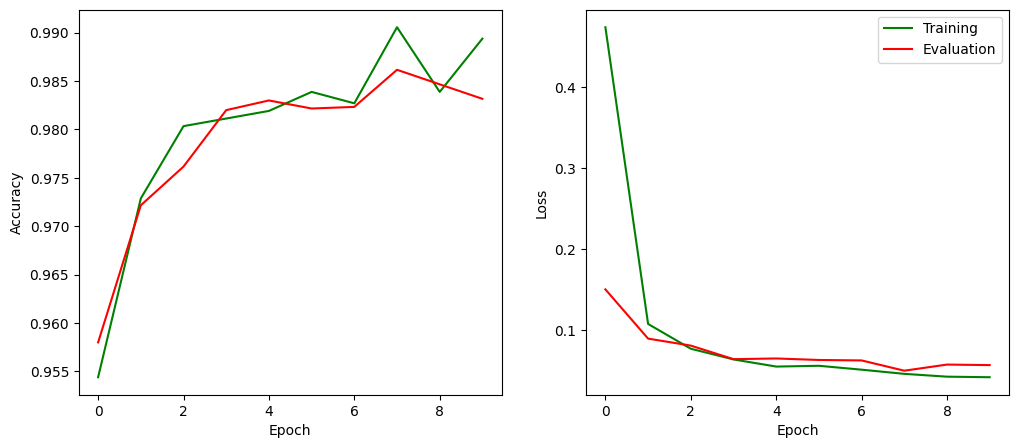

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(train_accs, color='green')
ax[0].plot(eval_accs, color='red')
ax[0].set(xlabel='Epoch', ylabel='Accuracy')

ax[1].plot(train_losses, color='green')
ax[1].plot(eval_losses, color='red')
ax[1].set(xlabel='Epoch', ylabel='Loss')
ax[1].legend(['Training', 'Evaluation'])

plt.show()

In [11]:
test_set.transform = test_transforms
test_loader = data.DataLoader(
    test_set,
    batch_size=BATCH_SIZE
)
test_acc, test_loss = evaluate(lenet_model, device, test_loader, criterion)
test_acc, test_loss

(0.9852, 0.04195387559666415)